In [31]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import nilearn
from nilearn import input_data
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import scale
from nilearn.image.image import mean_img
from nilearn.image import index_img
from nilearn.decomposition import DictLearning, CanICA
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show, plot_epi, plot_prob_atlas, find_xyz_cut_coords, plot_roi
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_epi, show
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction import image
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
import time

import os
import gzip
import shutil

In [74]:
basedir_PD = '/Volumes/myFatDrive/adaproject/PD/'
basedir_control = '/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/'

#basedir_PD = '/Volumes/myFatDrive/PPMI/-PPMI_nifti/PD/'
#basedir_control = '/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/'

task = '/ep2d_RESTING_STATE/'

func_filesPD = []
anat_filesPD = []

for fn in sorted(os.listdir(basedir_PD)):
    if fn[0]=='3' or fn[0]=='4':
        print(fn)
        for fn2 in sorted(os.listdir(basedir_PD+fn+task)):
            if fn2[0]=='2':
                print(fn2)
                func_filesPD.append(basedir_PD+fn+task+fn2+'/swrrest.nii')
                anat_filesPD.append(basedir_PD+fn+task+fn2+'/wranat_t1.nii')

func_filesControl = []
anat_filesControl = []

for fn in sorted(os.listdir(basedir_control)):
    if fn[0]=='3' or fn[0]=='4':
        print(fn)
        for fn2 in sorted(os.listdir(basedir_control+fn+task)):
            if fn2[0]=='2':
                print(fn2)
                func_filesControl.append(basedir_control+fn+task+fn2+'/swrrest.nii')
                anat_filesControl.append(basedir_control+fn+task+fn2+'/wranat_t1.nii')



3105
2013-04-18_12_01_06
2015-03-30_15_27_11
3108
2013-04-24_10_04_37
2015-05-06_09_33_18
3113
2013-07-17_11_20_44
3116
2012-11-14_11_13_50
2013-11-13_12_55_49
3118
2013-01-23_10_03_16
2014-02-19_11_54_26
3119
2013-02-20_11_12_17
2014-03-12_09_57_23
3120
2013-04-17_10_25_22
3123
2013-06-19_10_41_38
2014-05-21_10_08_14
3124
2013-07-17_09_16_34
2014-05-28_11_40_30
3126
2013-09-18_10_59_00
2014-07-23_11_55_03
3128
2013-09-19_11_23_27
2014-10-30_08_41_33
3131
2015-03-11_10_35_28
3132
2014-03-26_13_51_00
2015-04-28_09_15_15
3134
2013-04-22_09_22_01
2014-05-07_11_39_24
3327
2012-11-29_12_12_31
2013-12-20_14_08_14
3332
2013-04-23_12_43_50
3354
2013-03-28_09_44_54
2015-04-06_08_41_59
3360
2013-07-31_08_57_43
2015-04-29_08_32_35
3364
2013-06-25_11_00_27
2015-04-16_08_35_13
3365
2013-10-09_08_33_27
3366
2013-09-11_08_38_52
3367
2013-08-15_08_16_03
2015-08-12_08_29_52
3371
2013-02-01_09_41_08
3372
2013-02-27_08_43_28
2014-03-12_08_44_23
3374
2013-07-29_10_39_31
2014-04-16_09_39_42
3375
2013-07-05

## Loading anat and func

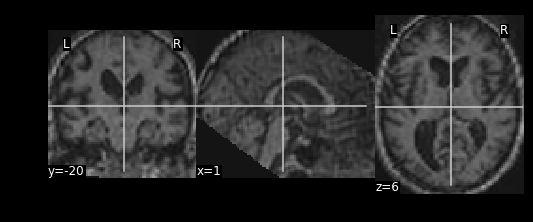

Anatomical MRI image


In [24]:
nilearn.plotting.plot_anat(anat_filesPD[0])
show()
print('Anatomical MRI image')

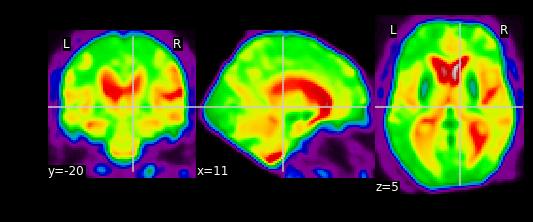

Mean of fMRI image over time


In [29]:
# Compute the mean EPI: we do the mean along the axis 3, which is time
mean_haxby = mean_img(func_filesPD[1])

plot_epi(mean_haxby)
show()

print('Mean of fMRI image over time')

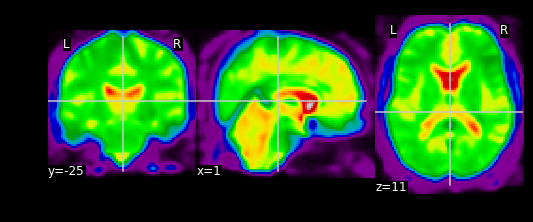

Mean of fMRI image over time


In [30]:
# Compute the mean EPI: we do the mean along the axis 3, which is time
mean_haxby = mean_img(func_filesControl[1])

plot_epi(mean_haxby)
show()

print('Mean of fMRI image over time')

## Extracting a brain mask

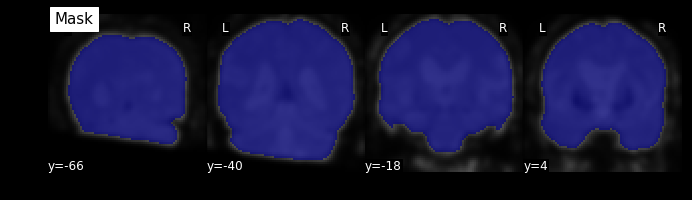

/Users/elisabettamessina/.local/lib/python3.6/site-packages/nilearn/input_data/base_masker.py:98: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


In [43]:
# As this is raw resting-state EPI, the background is noisy and we cannot
# rely on the 'background' masking strategy. We need to use the 'epi' one
nifti_masker = NiftiMasker(standardize=True, mask_strategy='epi',
                           memory="nilearn_cache", memory_level=2,
                           smoothing_fwhm=8)
nifti_masker.fit(func_filesPD[0])
mask_img = nifti_masker.mask_img_

# calculate mean image for the background
mean_func_img = mean_img(func_filesPD[0])

plot_roi(mask_img, mean_func_img, display_mode='y', cut_coords=4, title="Mask")
show()

# The fit_transform call computes the mask and extracts the time-series
# from the files:
fmri_masked = nifti_masker.fit_transform(func_filesPD[0])

# We can retrieve the numpy array of the mask
mask = nifti_masker.mask_img_.get_data().astype(bool)

## Extract time series

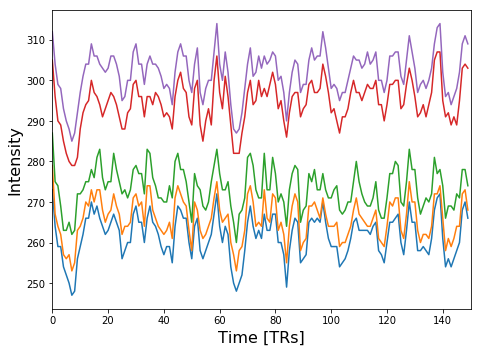

In [41]:
masked_data = apply_mask(func_filesControl[1], mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 150
# timepoints from two voxels

# And now plot a few of these
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:150, :5])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()

## Try fast ICA

In [44]:
n_components = 10
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(fmri_masked.T).T

components = nifti_masker.inverse_transform(components_masked)

# Visualize results
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img

plot_stat_map(index_img(components, 0), mean_func_img,
              display_mode='y', cut_coords=4, title="Component 0")

show()

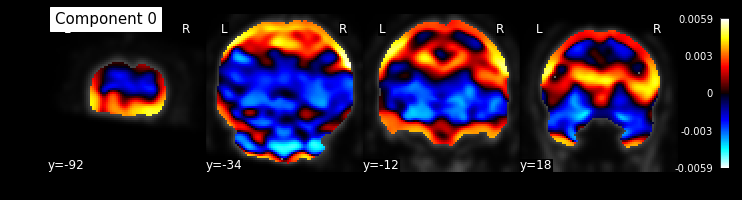

 ### Ward clustering

In [48]:
# Compute connectivity matrix: which voxel is connected to which


shape = mask.shape
connectivity = image.grid_to_graph(n_x=shape[0], n_y=shape[1],
                                   n_z=shape[2], mask=mask)

start = time.time()
ward = FeatureAgglomeration(n_clusters=1000, connectivity=connectivity,
                            linkage='ward', memory='nilearn_cache')
ward.fit(fmri_masked)
print("Ward agglomeration 1000 clusters: %.2fs" % (time.time() - start))


# Unmask the labels

# Avoid 0 label
labels = ward.labels_ + 1
labels_img = nifti_masker.inverse_transform(labels)

from nilearn.image import mean_img
mean_func_img = mean_img(func_filesPD[0])


first_plot = plot_roi(labels_img, mean_func_img, title="Ward parcellation",
                      display_mode='xz')

# common cut coordinates for all plots
cut_coords = first_plot.cut_coords




show()


#SAVE
#labels_img.to_filename('parcellation.nii')

Ward agglomeration 1000 clusters: 0.60s


NameError: name 'func_file' is not defined

## ICA group analysis

In [54]:
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filesPD)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)
# SAVE
components_img.to_filename('canica_resting_state.nii.gz')

[MultiNiftiMasker.fit] Loading data from [/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii, /Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii, /Volumes/myFatDri
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  4.4min finished


[MultiNiftiMasker.transform] Resampling mask
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3108/ep2d_RESTING_STATE/2013-04-24_10_04_37/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.t

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


_________________________________________________________fastica - 35.2s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=398764591)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


_________________________________________________________fastica - 36.4s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


_________________________________________________________fastica - 38.4s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


__________________________________________________________fastica - 7.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


_________________________________________________________fastica - 38.3s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s


_________________________________________________________fastica - 15.2s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s


__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.9min remaining:    0.0s


_________________________________________________________fastica - 19.6s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.3min remaining:    0.0s


__________________________________________________________fastica - 6.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001863, ..., -0.001525],
       ..., 
       [ 0.001751, ..., -0.000373]]), whiten=True, fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.4min remaining:    0.0s


__________________________________________________________fastica - 6.5s, 0.1min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.5min finished


/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


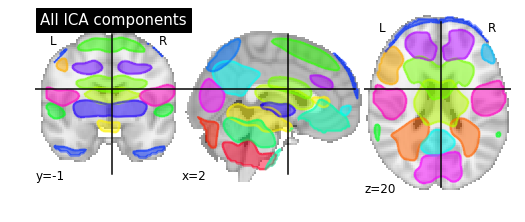

In [55]:
# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')
show()

In [56]:
components_img.to_filename('canica_resting_statePD.nii.gz')

In [75]:
%%time
#Second group
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filesControl)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)
# SAVE
#components_img.to_filename('canica_resting_stateControl.nii.gz')

[MultiNiftiMasker.fit] Loading data from [/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/3106/ep2d_RESTING_STATE/2015-03-30_14_21_51/swrrest.nii, /Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/3310/ep2d_RESTING_STATE/2013-02-13_13_00_53/swrrest.
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.3min finished


[MultiNiftiMasker.transform] Resampling mask
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/3106/ep2d_RESTING_STATE/2015-03-30_14_21_51/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/3310/ep2d_RESTING_STATE/2013-02-13_13_00_53/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/PPMI/-PPMI_nifti/Control/3318/ep2d_RESTING_STATE/2013-04-18_10_07_18/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


__________________________________________________________fastica - 5.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


_________________________________________________________fastica - 11.0s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s remaining:    0.0s


__________________________________________________________fastica - 7.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   32.6s remaining:    0.0s


__________________________________________________________fastica - 8.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.7s remaining:    0.0s


_________________________________________________________fastica - 13.4s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.2s remaining:    0.0s
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


_________________________________________________________fastica - 33.1s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=1491434855)
__________________________________________________________fastica - 6.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.6min remaining:    0.0s


__________________________________________________________fastica - 7.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.001905, ...,  0.001438],
       ..., 
       [ 0.002417, ...,  0.00174 ]]), whiten=True, fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


__________________________________________________________fastica - 8.8s, 0.1min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


CPU times: user 11min 55s, sys: 54.8 s, total: 12min 49s
Wall time: 8min 13s


/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


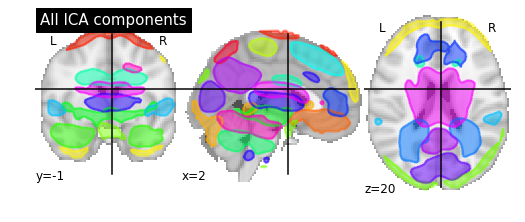

In [76]:
# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')
show()

In [77]:
components_img.to_filename('canica_resting_stateControl.nii.gz')

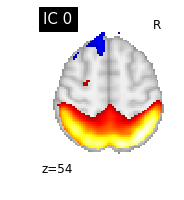

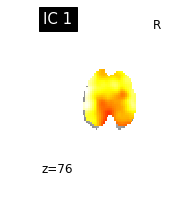

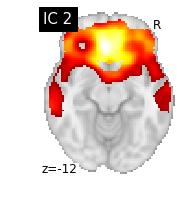

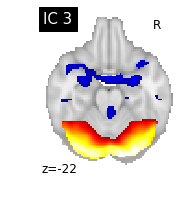

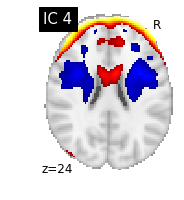

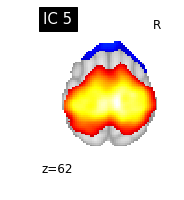

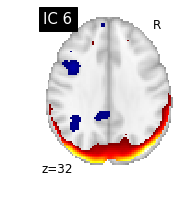

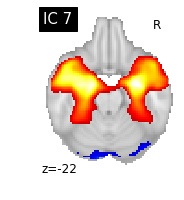

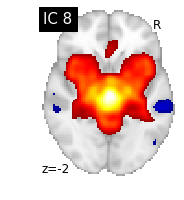

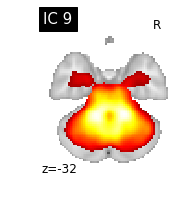

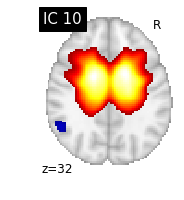

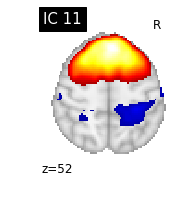

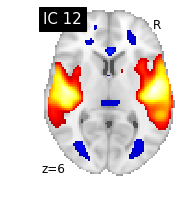

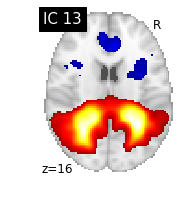

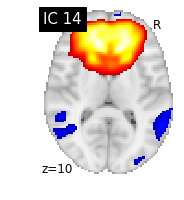

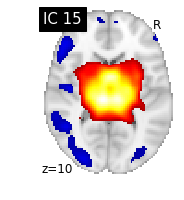

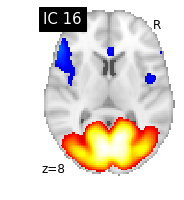

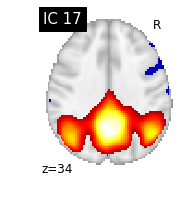

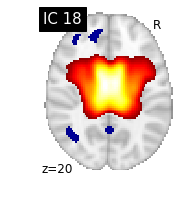

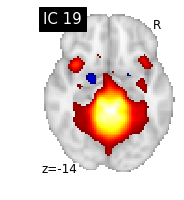

In [78]:
# plot the map for each ICA component separately
for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
show()

# Comparison Dictionary Learning and ICA
Create two decomposition estimators

In [79]:
n_components = 40

Dictionary learning

In [80]:
dict_learning = DictLearning(n_components=n_components,
                             memory="nilearn_cache", memory_level=2,
                             verbose=1,
                             random_state=0,
                             n_epochs=1)

In [81]:
canica = CanICA(n_components=n_components,
                memory="nilearn_cache", memory_level=2,
                threshold=3.,
                n_init=1,
                verbose=1)

Fit both estimators

In [ ]:
estimators = [dict_learning, canica]
names = {dict_learning: 'DictionaryLearning', canica: 'CanICA'}
components_imgs = []

for estimator in estimators:
    print('[Example] Learning maps using %s model' % names[estimator])
    estimator.fit(func_filesPD)
    print('[Example] Saving results')
    # Decomposition estimator embeds their own masker
    masker = estimator.masker_
    # Drop output maps to a Nifti   file
    components_img = masker.inverse_transform(estimator.components_)
    components_img.to_filename('%s_resting_state.nii.gz' %
                               names[estimator])
    components_imgs.append(components_img)

[Example] Learning maps using DictionaryLearning model
[MultiNiftiMasker.fit] Loading data from [/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii, /Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii, /Volumes/myFatDri
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMa

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/elisabettamessina/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:670: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/elisabettamessina/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


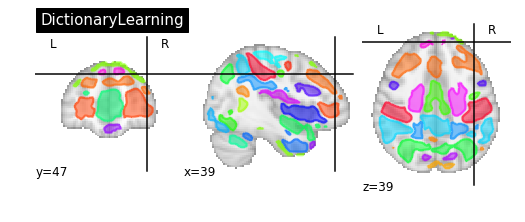

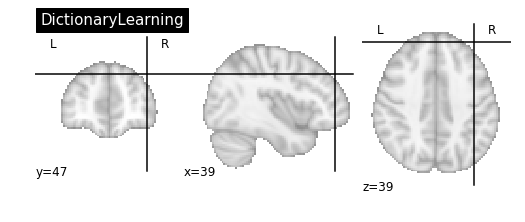

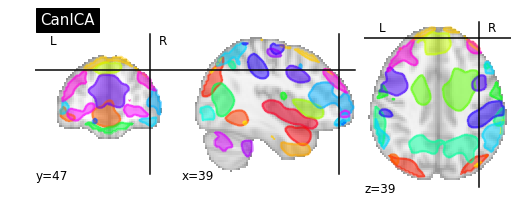

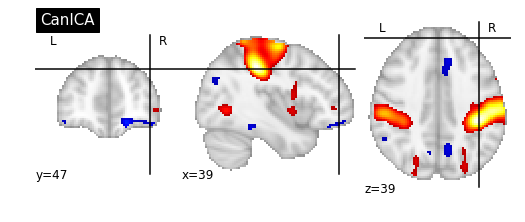

In [79]:

# Selecting specific maps to display: maps were manually chosen to be similar
indices = {dict_learning: 1, canica: 31}
# We select relevant cut coordinates for displaying
cut_component = index_img(components_imgs[0], indices[dict_learning])
cut_coords = find_xyz_cut_coords(cut_component)
for estimator, components in zip(estimators, components_imgs):
    # 4D plotting
    plot_prob_atlas(components, view_type="filled_contours",
                    title="%s" % names[estimator],
                    cut_coords=cut_coords, colorbar=False)
    # 3D plotting
    plot_stat_map(index_img(components, indices[estimator]),
                  title="%s" % names[estimator],
                  cut_coords=cut_coords, colorbar=False)
show()